# Distributed Tile-based Reading
The distributed tile-based reading shows how the ```DiskMappedLazyImage``` backend from ```pyqae.nd``` can be used to read large objects from memory in small pieces as a Spark RDD and a BoltArray (through the ```.unchunk()``` method. Currently two ```backends``` are implemented, a slower one (but more compatible / without requiring GDAL) using Pillow and a much faster one using GDAL. The notebook shows their relative performance and identical behavior. Additional backends can be made by extending the ```pyqae.nd.LazyImageBackend``` class (for example with hdf5)

In [9]:
# standard python tools
import numpy as np
from glob import glob

In [6]:
# make sure pyqae is available
import pyqae as pq
    
# check to see if it is running on pyspark (if not use the simplespark backend)
try:
    import pyspark
except ImportError:
    print('Using a fake spark backend for processing')

    import pyqae.simplespark as pyspark
    sc = pyspark.LocalSparkContext()

from pyqae.images import viz
# lazy image 
from pyqae.images.lazy import paths_to_tiled_image, DiskMappedLazyImage, backends

These are the test datasets with a stack of small images (384 x 384), a big image (22902 x 30021) and a really big image larger than 65000 x 65000 and requiring GDAL

In [7]:
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
little_image_list = glob(os.path.join(base_path,"0004_t1_tse_sag_384/*.tif"))
big_image_list = ['/Volumes/ExDisk/cor03639_CH2.tif']*5
really_big_image_list = ['/Volumes/TOSHIBA EXT/1616.tif']

In [8]:
help(DiskMappedLazyImage)

Help on class DiskMappedLazyImage in module pyqae.images.lazy:

class DiskMappedLazyImage(builtins.object)
 |  A lazily read image which behaves as if it were a numpy array, fully serializable
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Get an item from the array through indexing.
 |      Supports basic indexing with slices and ints, or advanced
 |      indexing with lists or ndarrays of integers.
 |      Mixing basic and advanced indexing across axes is currently supported
 |      only for a single advanced index amidst multiple basic indices.
 |      Parameters
 |      ----------
 |      index : tuple of slices
 |          One or more index specifications
 |      Returns
 |      -------
 |      NDArray
 |  
 |  __init__(self, path, bckend)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  _

/Users/mader/anaconda/lib/python3.5/site-packages/PIL/Image.py:2246: DecompressionBombWarning: Image size (687540942 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


<class 'pyqae.images.lazy.LazyImagePillowBackend'> (200, 200) 23.986589908599854s for loading
<class 'pyqae.images.lazy.LazyImageGDALBackend'> (200, 200) 0.09600400924682617s for loading


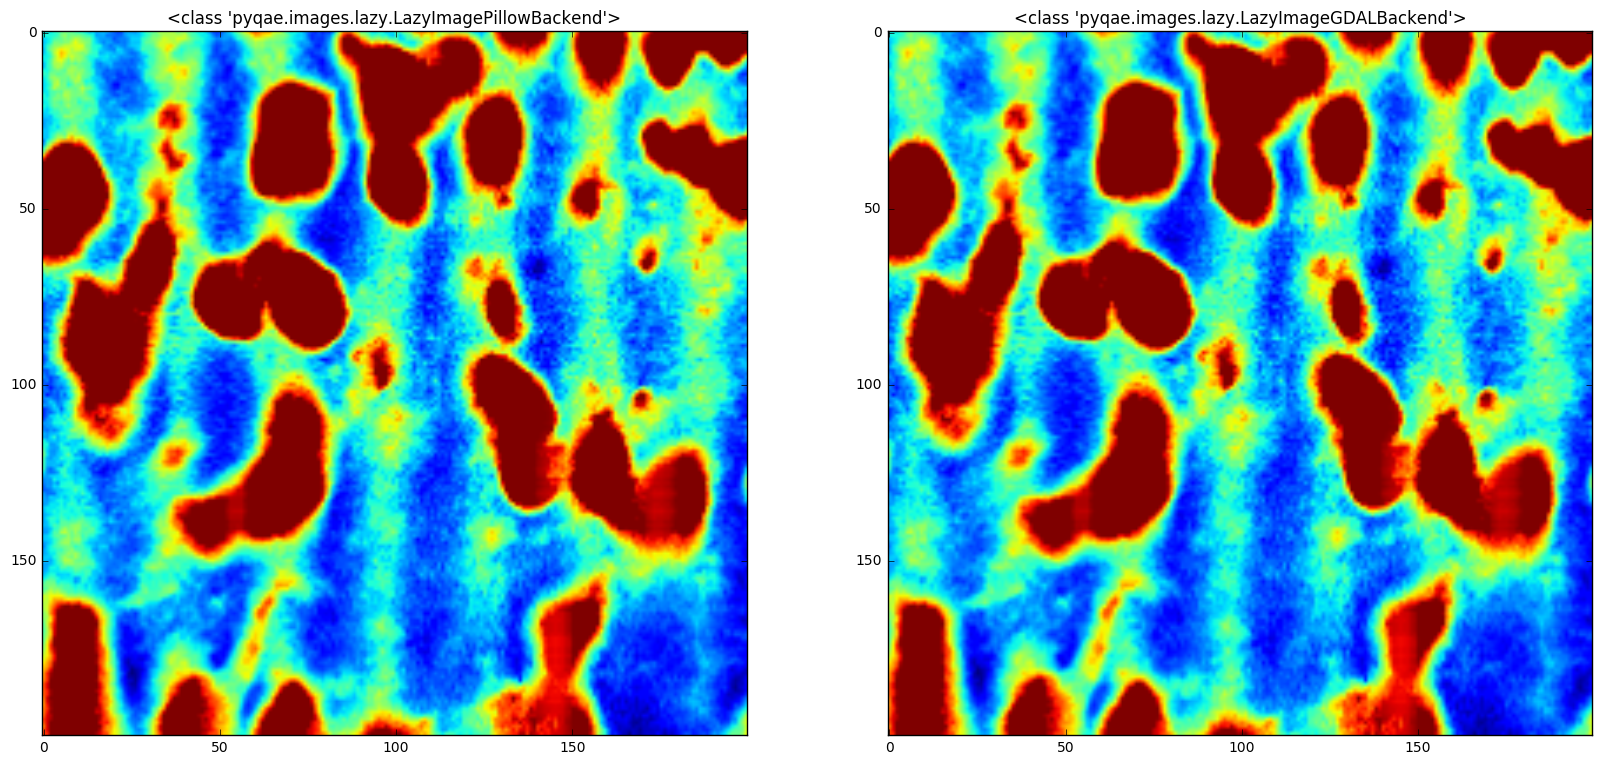

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
out_img_data = {}
for i_img in big_image_list[0:1]:
    fig, axs = plt.subplots(1, len(backends), figsize = (20, 10))
    for c_ax, c_back in zip(axs, backends):
        stime = time()
        c_image = DiskMappedLazyImage(i_img, c_back)[15000:15200, 15000:15200]
        print(c_back, c_image.shape, "{}s for loading".format(time()-stime))
        c_ax.imshow(c_image)
        c_ax.set_title(str(c_back))
        out_img_data[str(c_back)] = c_image

## Validation
The following checks the standard deviation (```std```) for each pixel in the images from the different backends and ensures the maximum value is less than 0.1 (since the images are ```uint8``` types)

In [11]:
assert np.max(np.std(np.stack([mat for (_, mat) in out_img_data.items()]),0))<0.1, "Tiles do not match between reading methods!"

# Interactive Browsing of Tiled Images
The ```show_lazy_browser``` function in the ```pyqae.images.viz``` library allows for images to be viewed interactively with controls for the slice number, x, y, and z positions. In this case it is one large slice where tiles of size 512 x 512 are read from disk and displayed.

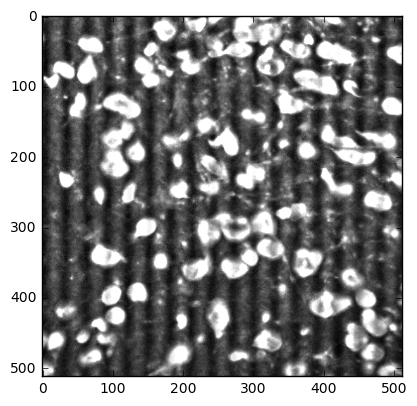

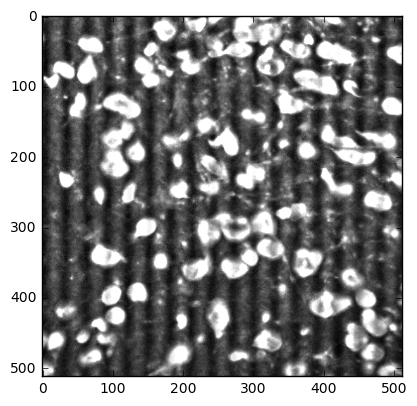

In [12]:
in_lz_image = DiskMappedLazyImage(big_image_list[0], backends[1])
_ = viz.show_lazy_browser(in_lz_image, tile_size = (512, 512))

In [8]:
help(paths_to_tiled_image)

Help on function paths_to_tiled_image in module pyqae.nd:

paths_to_tiled_image(paths, context=None, tile_size=(256, 256), padding=(0, 0), backend=<class 'pyqae.nd.LazyImageGDALBackend'>, skip_chunk=False, **kwargs)
    Create an tiled ND image from a collection of paths
    :param paths: List[str] / RDD[str] a list or RDD of strings containing image paths
    :param context: SparkContext the context to make the RDD from if paths is a list
    :param tile_size: the size of tiles to cut
    :param padding:  the padding to use
    :param backend: The LazyImageBackend to use for reading the image data in (by default uses the last one, GDAL if available)
    :param kwargs: other arguments for creating the initial RDD
    :return: a ChunkedRDD containing the image data as tiles (use .unchunk to make into a normal RDD)



In [4]:
dist_tile_rdd = paths_to_tiled_image(little_image_list[0:1], context = sc, backend = backends[-1])

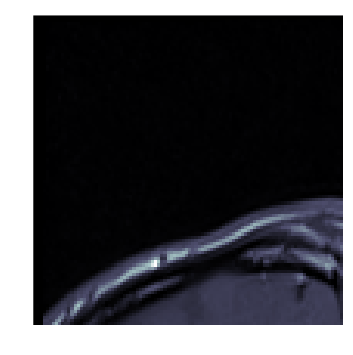

In [10]:
%matplotlib inline
_ = viz.show_image(dist_tile_rdd.unchunk()[0,0:100,0:100].toarray())

## Interactive Filtering
The tools can also be used for running a filter on an image and previewing the results on single tiles interactivey by using caching and the ```lazy_browser```

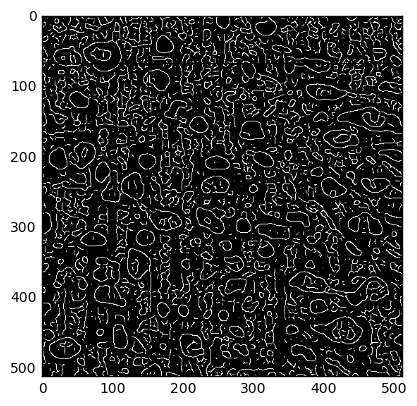

In [5]:
from skimage.feature import canny
dist_tile_rdd = paths_to_tiled_image(big_image_list[0:1], tile_size=(512, 512), context = sc)
simple_edge_filter = lambda x: canny(x.astype(np.float32),2.0)
lazy_out_image = dist_tile_rdd.map(simple_edge_filter).unchunk()
lazy_out_image.cache()
_ = viz.show_lazy_browser(lazy_out_image[0], tile_size=(512, 512))

# Workflow Visualization

The following serves as a visualization of the tile_processing workflow showing the different steps, types, data-sizes, and times involved at each step of the pipeline

Creating new RDD[string] from parallelize with 1 entries
Creating new RDD[(string, int)] from zipWithIndex with 1 entries
Creating new RDD[(int, DiskMappedLazyImage)] from map with 1 entries
Creating new RDD[((int, int, int), ndarray[uint8](1024, 1024))] from flatMap with 690 entries


/Users/mader/anaconda/lib/python3.5/site-packages/pyqae_python-0.20-py3.5.egg/pyqae/simplespark.py:94: RuntimeWarning: Partitioning not really supported yet
/Users/mader/anaconda/lib/python3.5/site-packages/pyqae_python-0.20-py3.5.egg/pyqae/simplespark.py:98: RuntimeWarning: Partitioning not really supported yet


Creating new RDD[((int), ndarray[uint8](22902, 30021))] from groupBy with 1 entries
Creating new RDD[((int), ndarray[uint8](22902, 30021))] from filter with 1 entries
Creating new RDD[((float), ndarray[uint8](100, 100))] from map with 1 entries
Creating new RDD[((), ndarray[uint8](100, 100))] from map with 1 entries


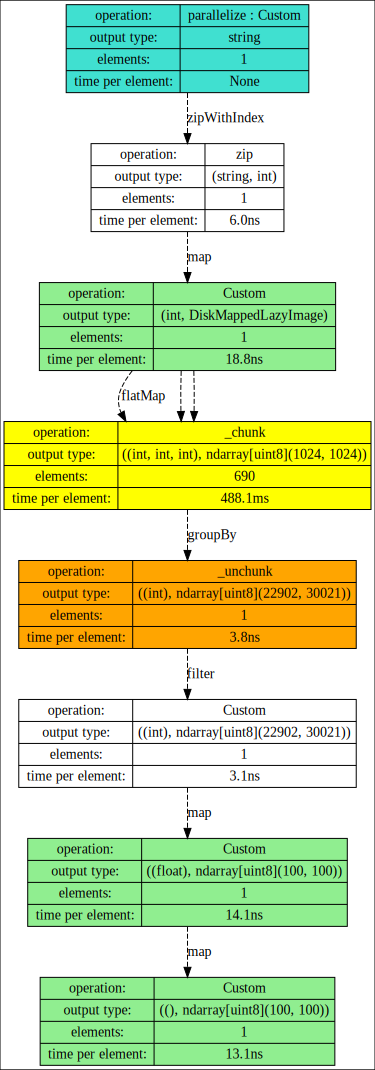

In [12]:
import pyqae.simplespark as pyspark
lsc = pyspark.LocalSparkContext(verbose = True)
from pyqae.rddviz import show_dag
dist_tile_rdd = paths_to_tiled_image(big_image_list[0:1], tile_size = (1024, 1024), context = lsc)
show_dag(dist_tile_rdd.unchunk()[0,0:100,0:100].tordd(), 'tile_read.svg')